In [1]:
import tensorflow as tf
config = tf.ConfigProto(allow_soft_placement=True) 
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dty

In [2]:
"""
Class definition of YOLO_v3 style detection model on image and video
"""

import colorsys
import os
from timeit import default_timer as timer

import numpy as np
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from PIL import Image, ImageFont, ImageDraw, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import cv2

from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from yolo3.utils import letterbox_image
import os
from keras.utils import multi_gpu_model

Using TensorFlow backend.


In [3]:
class YOLO(object):
    _defaults = {
        "model_path": 'model_data/trained_weights_final.h5', #指定YOLO訓練完成權重檔路徑及名稱
        "anchors_path": 'model_data/yolo_anchors.txt', #指定錨點定義檔路徑及名稱
        "classes_path": 'model_data/my_classes.txt', #指定自定義標籤檔路徑及名稱
        "score" : 0.6, #最低置信度門檻(0.01~0.99)
        "iou" : 0.6, #重疊區比例(0.01~1.0)
        "model_image_size" : (416, 416), #影像尺寸
        "gpu_num" : 1, #使用GPU數量
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        is_tiny_version = num_anchors==6 # default setting
        try:
            self.yolo_model = load_model(model_path, compile=False)
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes) \
                if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs.
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.
        np.random.seed(None)  # Reset seed to default.

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        if self.gpu_num>=2:
            self.yolo_model = multi_gpu_model(self.yolo_model, gpus=self.gpu_num)
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes

    def detect_image(self, image):
        start = timer()

        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
        thickness = (image.size[0] + image.size[1]) // 300

        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            print(label, (left, top), (right, bottom))

            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            # My kingdom for a good redistributable image drawing library.
            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[c])
            draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill=self.colors[c])
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw

        end = timer()
        print(end - start)
        return image

    def close_session(self):
        self.sess.close()

In [4]:
yolo=YOLO() #進行YOLO初始化

model_data/trained_weights_final.h5 model, anchors, and classes loaded.


In [5]:
if __name__ == '__main__':
    t0 = timer()
    path ='VOC2007//JPEGImages' #指定待測影像檔案路徑及名稱
    listimg = os.listdir(path) #list
     
    t1 = timer()
    for i in listimg:
        img = cv2.imread(path+"//"+i)#開啟待推論影像
        img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #轉換RGB
        print(i)
        
        t2 = timer()
        image = Image.fromarray(img_cvt) #轉換格式
        r_image = yolo.detect_image(image) #進行推論
        t3 = timer()            
        #r_image.show() #顯示有標示物件框的結果影像
        
        image.save("test_save//"+i , quality=100) #儲存圖片
        
        print('Yolo inital: %f sec' %(t1-t0)) #計算及顯示YOLO初始化時間
        print('Image load: %f sec' %(t2-t1)) #計算及顯示影像載入時間
        print('Detect object: %f sec\n' %(t3-t2)) #計算偵測物件時間

    yolo.close_session() #結束YOLO工作

00001.jpg
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (125, 132) (311, 246)
8.6833484
Yolo inital: 0.261164 sec
Image load: 0.026691 sec
Detect object: 8.700129 sec

00002.jpg
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.86 (200, 111) (416, 301)
kangaroo 0.87 (144, 105) (416, 298)
0.6516534000000007
Yolo inital: 0.261164 sec
Image load: 9.077198 sec
Detect object: 0.653202 sec

00003.jpg
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.85 (89, 74) (445, 253)
kangaroo 0.95 (107, 4) (424, 288)
kangaroo 0.96 (254, 0) (460, 242)
0.5585104999999988
Yolo inital: 0.261164 sec
Image load: 9.755059 sec
Detect object: 0.559381 sec

00004.jpg
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.85 (36, 97) (322, 195)
kangaroo 0.96 (41, 81) (288, 216)
0.8062071
Yolo inital: 0.261164 sec
Image load: 10.320037 sec
Detect object: 0.806855 sec

00005.jpg
(416, 416, 3)
Found 0 boxes for img
0.44188529999999915
Yolo inital: 0.261164 sec
Image load: 11.137971 sec
Detect object: 0.443917 sec

00006.jpg
(4

Found 0 boxes for img
0.47781559999999956
Yolo inital: 0.261164 sec
Image load: 34.202834 sec
Detect object: 0.479655 sec

00045.jpg
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (268, 183) (472, 385)
0.6270996999999952
Yolo inital: 0.261164 sec
Image load: 35.091448 sec
Detect object: 0.628576 sec

00046.jpg
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (290, 129) (570, 324)
0.403045199999994
Yolo inital: 0.261164 sec
Image load: 35.726756 sec
Detect object: 0.404036 sec

00047.jpg
(416, 416, 3)
Found 0 boxes for img
0.665343
Yolo inital: 0.261164 sec
Image load: 36.145352 sec
Detect object: 0.666092 sec

00048.jpg
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.83 (402, 174) (544, 253)
0.5911654000000013
Yolo inital: 0.261164 sec
Image load: 36.819436 sec
Detect object: 0.591857 sec

00049.jpg
(416, 416, 3)
Found 2 boxes for img
raccoon 0.94 (0, 76) (352, 400)
kangaroo 0.99 (324, 109) (571, 413)
0.7188038999999975
Yolo inital: 0.261164 sec
Image load: 37.421230 sec
Detect obje

Found 1 boxes for img
raccoon 0.92 (105, 46) (271, 320)
0.5386319999999927
Yolo inital: 0.261164 sec
Image load: 64.617228 sec
Detect object: 0.539665 sec

00093.jpg
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (453, 0) (808, 442)
0.11638470000001178
Yolo inital: 0.261164 sec
Image load: 65.410251 sec
Detect object: 0.120837 sec

00094.jpg
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (158, 0) (354, 400)
0.1398859000000101
Yolo inital: 0.261164 sec
Image load: 65.542363 sec
Detect object: 0.140645 sec

00095.jpg
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (380, 136) (605, 343)
0.11452359999999828
Yolo inital: 0.261164 sec
Image load: 65.690964 sec
Detect object: 0.115509 sec

00096.jpg
(416, 416, 3)
Found 0 boxes for img
0.11397110000000055
Yolo inital: 0.261164 sec
Image load: 65.819396 sec
Detect object: 0.117514 sec

00097.jpg
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.81 (8, 117) (894, 571)
kangaroo 0.83 (183, 134) (737, 529)
0.12165900000000818
Yolo inital: 0.26

Found 5 boxes for img
kangaroo 0.81 (84, 0) (380, 326)
kangaroo 0.82 (103, 31) (362, 274)
kangaroo 0.84 (129, 46) (376, 263)
kangaroo 0.91 (85, 67) (409, 243)
kangaroo 0.99 (77, 22) (383, 292)
0.23046970000000044
Yolo inital: 0.261164 sec
Image load: 75.383212 sec
Detect object: 0.231365 sec

00143.jpg
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.81 (506, 267) (942, 637)
kangaroo 0.89 (459, 291) (974, 646)
kangaroo 0.94 (438, 255) (924, 683)
kangaroo 0.95 (489, 193) (883, 683)
0.23923430000000678
Yolo inital: 0.261164 sec
Image load: 75.641698 sec
Detect object: 0.241972 sec

00144.jpg
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.87 (100, 63) (624, 527)
kangaroo 0.91 (192, 35) (583, 575)
kangaroo 0.95 (111, 120) (655, 502)
kangaroo 0.97 (123, 0) (601, 600)
0.23162570000000926
Yolo inital: 0.261164 sec
Image load: 75.900438 sec
Detect object: 0.233329 sec

00145.jpg
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.91 (237, 7) (370, 333)
kangaroo 0.99 (215, 67) (400, 306)
0.33737739999

Found 2 boxes for img
raccoon 0.82 (171, 125) (486, 374)
raccoon 0.99 (51, 137) (593, 359)
0.23044389999999737
Yolo inital: 0.261164 sec
Image load: 86.641235 sec
Detect object: 0.231715 sec

raccoon-10.jpg
(416, 416, 3)
Found 2 boxes for img
raccoon 1.00 (122, 12) (450, 422)
raccoon 1.00 (129, 0) (450, 495)
0.23206189999999083
Yolo inital: 0.261164 sec
Image load: 86.889225 sec
Detect object: 0.232751 sec

raccoon-100.jpg
(416, 416, 3)
Found 0 boxes for img
0.22062930000001302
Yolo inital: 0.261164 sec
Image load: 87.145893 sec
Detect object: 0.222055 sec

raccoon-101.jpg
(416, 416, 3)
Found 2 boxes for img
raccoon 0.81 (85, 24) (394, 390)
raccoon 0.97 (66, 75) (456, 336)
0.2299462999999946
Yolo inital: 0.261164 sec
Image load: 87.378066 sec
Detect object: 0.231128 sec

raccoon-102.jpg
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (0, 12) (146, 143)
0.22678109999999663
Yolo inital: 0.261164 sec
Image load: 87.627607 sec
Detect object: 0.227660 sec

raccoon-103.jpg
(416, 416, 3)
Fou

Found 2 boxes for img
raccoon 0.87 (18, 0) (242, 153)
raccoon 0.93 (0, 13) (259, 129)
0.22994400000000326
Yolo inital: 0.261164 sec
Image load: 98.278226 sec
Detect object: 0.230461 sec

raccoon-133.jpg
(416, 416, 3)
Found 4 boxes for img
raccoon 0.93 (0, 0) (490, 640)
raccoon 1.00 (36, 0) (470, 631)
raccoon 1.00 (18, 5) (490, 615)
raccoon 1.00 (0, 0) (490, 627)
0.22235009999999988
Yolo inital: 0.261164 sec
Image load: 98.539035 sec
Detect object: 0.223492 sec

raccoon-134.jpg
(416, 416, 3)
Found 0 boxes for img
0.7025258999999977
Yolo inital: 0.261164 sec
Image load: 98.781770 sec
Detect object: 0.703070 sec

raccoon-135.jpg
(416, 416, 3)
Found 4 boxes for img
raccoon 0.82 (133, 5) (640, 412)
raccoon 0.98 (136, 15) (591, 348)
raccoon 0.99 (4, 8) (640, 392)
raccoon 1.00 (76, 38) (640, 360)
0.23286699999999882
Yolo inital: 0.261164 sec
Image load: 99.492386 sec
Detect object: 0.234113 sec

raccoon-136.jpg
(416, 416, 3)
Found 0 boxes for img
0.22545159999999953
Yolo inital: 0.261164 sec


raccoon-166.jpg
(416, 416, 3)
Found 0 boxes for img
0.4907005999999967
Yolo inital: 0.261164 sec
Image load: 108.547321 sec
Detect object: 0.492015 sec

raccoon-167.jpg
(416, 416, 3)
Found 4 boxes for img
raccoon 0.90 (0, 0) (168, 195)
raccoon 1.00 (0, 4) (259, 191)
raccoon 1.00 (3, 0) (180, 195)
raccoon 1.00 (0, 1) (225, 195)
0.3384430999999921
Yolo inital: 0.261164 sec
Image load: 109.042501 sec
Detect object: 0.339317 sec

raccoon-168.jpg
(416, 416, 3)
Found 0 boxes for img
0.4745640000000009
Yolo inital: 0.261164 sec
Image load: 109.503528 sec
Detect object: 0.475226 sec

raccoon-169.jpg
(416, 416, 3)
Found 3 boxes for img
raccoon 0.92 (128, 26) (613, 383)
raccoon 0.95 (208, 21) (594, 399)
raccoon 0.97 (243, 0) (559, 409)
0.5049903000000029
Yolo inital: 0.261164 sec
Image load: 110.035489 sec
Detect object: 0.505672 sec

raccoon-17.jpg
(416, 416, 3)
Found 0 boxes for img
0.4610540000000043
Yolo inital: 0.261164 sec
Image load: 110.556486 sec
Detect object: 0.461398 sec

raccoon-170

Found 1 boxes for img
raccoon 0.89 (43, 21) (261, 160)
0.10755029999999977
Yolo inital: 0.261164 sec
Image load: 127.203680 sec
Detect object: 0.108114 sec

raccoon-21.jpg
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (55, 17) (234, 156)
0.10764740000000472
Yolo inital: 0.261164 sec
Image load: 127.315345 sec
Detect object: 0.108081 sec

raccoon-22.jpg
(416, 416, 3)
Found 2 boxes for img
raccoon 0.85 (277, 105) (471, 316)
raccoon 0.97 (248, 107) (495, 285)
0.11017969999998911
Yolo inital: 0.261164 sec
Image load: 127.430484 sec
Detect object: 0.110741 sec

raccoon-23.jpg
(416, 416, 3)
Found 2 boxes for img
raccoon 1.00 (73, 9) (259, 182)
raccoon 1.00 (110, 0) (259, 194)
0.1089149999999961
Yolo inital: 0.261164 sec
Image load: 127.556081 sec
Detect object: 0.109352 sec

raccoon-24.jpg
(416, 416, 3)
Found 0 boxes for img
0.10565139999999928
Yolo inital: 0.261164 sec
Image load: 127.668752 sec
Detect object: 0.106048 sec

raccoon-25.jpg
(416, 416, 3)
Found 0 boxes for img
0.10844070000

Found 3 boxes for img
raccoon 0.82 (89, 45) (193, 177)
raccoon 0.94 (86, 47) (178, 162)
raccoon 0.99 (80, 32) (185, 190)
0.11104230000000825
Yolo inital: 0.261164 sec
Image load: 131.646797 sec
Detect object: 0.111681 sec

raccoon-54.jpg
(416, 416, 3)
Found 3 boxes for img
raccoon 0.87 (108, 58) (518, 279)
raccoon 0.98 (135, 17) (549, 315)
raccoon 0.99 (51, 42) (572, 289)
0.11155530000002045
Yolo inital: 0.261164 sec
Image load: 131.764288 sec
Detect object: 0.112074 sec

raccoon-55.jpg
(416, 416, 3)
Found 3 boxes for img
raccoon 0.83 (271, 32) (536, 417)
raccoon 0.98 (23, 2) (233, 345)
raccoon 0.99 (221, 62) (600, 374)
0.11566329999999425
Yolo inital: 0.261164 sec
Image load: 131.892615 sec
Detect object: 0.116760 sec

raccoon-56.jpg
(416, 416, 3)
Found 3 boxes for img
raccoon 0.96 (8, 0) (235, 189)
raccoon 1.00 (32, 16) (236, 190)
raccoon 1.00 (0, 0) (240, 204)
0.1117840000000001
Yolo inital: 0.261164 sec
Image load: 132.014673 sec
Detect object: 0.112286 sec

raccoon-57.jpg
(416, 41

Found 4 boxes for img
raccoon 0.85 (199, 140) (589, 352)
raccoon 0.87 (221, 86) (505, 437)
raccoon 0.91 (20, 84) (152, 465)
raccoon 0.97 (219, 116) (509, 377)
0.11420370000001867
Yolo inital: 0.261164 sec
Image load: 136.421013 sec
Detect object: 0.115238 sec

raccoon-86.jpg
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (183, 26) (433, 389)
0.10942039999997633
Yolo inital: 0.261164 sec
Image load: 136.543168 sec
Detect object: 0.110146 sec

raccoon-87.jpg
(416, 416, 3)
Found 2 boxes for img
raccoon 0.99 (0, 0) (232, 191)
raccoon 1.00 (0, 14) (228, 176)
0.11066880000001333
Yolo inital: 0.261164 sec
Image load: 136.666864 sec
Detect object: 0.111120 sec

raccoon-88.jpg
(416, 416, 3)
Found 2 boxes for img
raccoon 0.93 (51, 66) (527, 414)
raccoon 0.98 (138, 81) (497, 405)
0.1117701000000011
Yolo inital: 0.261164 sec
Image load: 136.786517 sec
Detect object: 0.112714 sec

raccoon-89.jpg
(416, 416, 3)
Found 2 boxes for img
raccoon 0.99 (0, 5) (259, 178)
raccoon 1.00 (14, 23) (243, 157)
0.

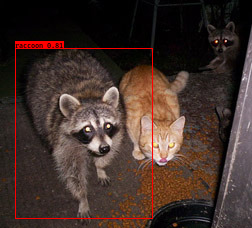

In [6]:
r_image

In [5]:
def detect_video(yolo, video_path, output_path=""):
    import cv2
    vid = cv2.VideoCapture(video_path)
    # 使用 XVID 編碼
    fourcc = cv2.VideoWriter_fourcc(*'XVID')

    # 建立 VideoWriter 物件，輸出影片至 output.avi
    # FPS 值為 30.0，解析度為 1280*720
    out = cv2.VideoWriter(output_path+'Kangaroo-detection.avi', fourcc, 30.0, (1280, 720))
    
#     if not vid.isOpened():
#         raise IOError("Couldn't open webcam or video")
        
#     video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
#     video_fps       = vid.get(cv2.CAP_PROP_FPS)
#     video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
#                         int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))
     
#     if output_path != "":
#         isOutput = True
#     else:
#         isOutput = False
    
#     if isOutput:
#         print("!!! TYPE:", type(output_path), type(video_FourCC), type(video_fps), type(video_size))
#         out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)
        
    accum_time = 0
    curr_fps = 0
    fps = "FPS: ??"
    prev_time = timer()
    
    while True:
        return_value, frame = vid.read()
        
        if frame is None:
             break
        
        image = Image.fromarray(frame)
        image = yolo.detect_image(image)
        result = np.asarray(image)
        curr_time = timer()
        exec_time = curr_time - prev_time
        prev_time = curr_time
        accum_time = accum_time + exec_time
        curr_fps = curr_fps + 1
        
        if accum_time > 1:
            accum_time = accum_time - 1
            fps = "FPS: " + str(curr_fps)
            curr_fps = 0
            
        cv2.putText(result, text=fps, org=(3, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.50, color=(255, 0, 0), thickness=2)
        cv2.namedWindow("result", cv2.WINDOW_NORMAL)
        cv2.imshow("result", result)
        out.write(result)
        
#         if isOutput:
#             out.write(result)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
    # 釋放所有資源
    vid.release()
    out.release()
    cv2.destroyAllWindows()
        
    yolo.close_session()

In [6]:
path ='D://Program Code//Python//ML//DL-馬拉松//Final//Kangaroo.mp4' #指定待測影像檔案路徑及名稱
Output = 'D://Program Code//Python//ML//DL-馬拉松//Final//' 
detect_video(yolo,path,Output)

(416, 416, 3)
Found 0 boxes for img
2.9478033999999997
(416, 416, 3)
Found 0 boxes for img
0.11426170000000013
(416, 416, 3)
Found 0 boxes for img
0.1111901999999998
(416, 416, 3)
Found 0 boxes for img
0.11030849999999992
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (62, 0) (452, 715)
0.11366019999999999
(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (55, 0) (463, 627)
0.11217949999999943
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (56, 0) (461, 631)
0.11364109999999972
(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (52, 0) (472, 632)
0.11521890000000035
(416, 416, 3)
Found 1 boxes for img
raccoon 0.62 (57, 0) (472, 638)
0.1266620999999999
(416, 416, 3)
Found 0 boxes for img
0.1266632999999997
(416, 416, 3)
Found 0 boxes for img
0.11066739999999964
(416, 416, 3)
Found 0 boxes for img
0.11202489999999976
(416, 416, 3)
Found 0 boxes for img
0.11111350000000009
(416, 416, 3)
Found 0 boxes for img
0.11100620000000028
(416, 416, 3)
Found 0 boxes for img
0.1108469999999997
(416,

Found 0 boxes for img
0.11006229999999917
(416, 416, 3)
Found 0 boxes for img
0.11083770000000115
(416, 416, 3)
Found 0 boxes for img
0.11034480000000002
(416, 416, 3)
Found 0 boxes for img
0.10975859999999926
(416, 416, 3)
Found 0 boxes for img
0.11003699999999839
(416, 416, 3)
Found 0 boxes for img
0.11018379999999794
(416, 416, 3)
Found 0 boxes for img
0.11011669999999896
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (467, 117) (1178, 622)
0.11310990000000132
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (462, 83) (1182, 648)
0.11247729999999834
(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (498, 44) (1167, 699)
0.11307659999999942
(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (496, 47) (1170, 697)
0.11211480000000051
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (521, 24) (1154, 720)
0.11250240000000034
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (537, 10) (1136, 720)
0.11251980000000117
(416, 416, 3)
Found 0 boxes for img
0.11061600000000027
(416, 416, 3)
Found

Found 1 boxes for img
raccoon 0.73 (0, 0) (1110, 693)
0.1124153000000021
(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (0, 41) (1060, 635)
0.11216389999999876
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (1, 42) (1055, 634)
0.11225480000000232
(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (10, 41) (1051, 633)
0.11251620000000173
(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (44, 72) (1005, 613)
0.11244580000000326
(416, 416, 3)
Found 0 boxes for img
0.10969599999999957
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.62 (0, 87) (931, 595)
0.11288039999999455
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.61 (0, 87) (931, 595)
0.11282650000000416
(416, 416, 3)
Found 0 boxes for img
0.11011479999999807
(416, 416, 3)
Found 0 boxes for img
0.12271790000000493
(416, 416, 3)
Found 0 boxes for img
0.11082110000000256
(416, 416, 3)
Found 0 boxes for img
0.11007399999999734
(416, 416, 3)
Found 0 boxes for img
0.11050490000000224
(416, 416, 3)
Found 0 boxes for img
0.11119380000000234

Found 1 boxes for img
kangaroo 0.72 (137, 135) (363, 457)
0.1125924999999981
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.64 (148, 121) (355, 464)
0.11249940000000436
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.60 (150, 115) (354, 466)
0.1126873000000046
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.61 (148, 114) (350, 466)
0.1126655999999997
(416, 416, 3)
Found 0 boxes for img
0.11002679999999998
(416, 416, 3)
Found 0 boxes for img
0.10987349999999907
(416, 416, 3)
Found 0 boxes for img
0.1107580999999982
(416, 416, 3)
Found 0 boxes for img
0.11088940000000491
(416, 416, 3)
Found 0 boxes for img
0.11003709999999955
(416, 416, 3)
Found 0 boxes for img
0.11008089999999982
(416, 416, 3)
Found 0 boxes for img
0.11063030000000396
(416, 416, 3)
Found 0 boxes for img
0.11035859999999786
(416, 416, 3)
Found 0 boxes for img
0.11025360000000006
(416, 416, 3)
Found 0 boxes for img
0.11009070000000065
(416, 416, 3)
Found 0 boxes for img
0.11056349999999782
(416, 416, 3)
Found 0 boxes for im

(416, 416, 3)
Found 0 boxes for img
0.11218939999999122
(416, 416, 3)
Found 0 boxes for img
0.11115759999999852
(416, 416, 3)
Found 0 boxes for img
0.11007850000000019
(416, 416, 3)
Found 0 boxes for img
0.11048040000000015
(416, 416, 3)
Found 0 boxes for img
0.10994130000000268
(416, 416, 3)
Found 0 boxes for img
0.11056010000000072
(416, 416, 3)
Found 0 boxes for img
0.11052300000000059
(416, 416, 3)
Found 0 boxes for img
0.11054540000000657
(416, 416, 3)
Found 0 boxes for img
0.12854600000000005
(416, 416, 3)
Found 0 boxes for img
0.11089629999999318
(416, 416, 3)
Found 0 boxes for img
0.11008289999999477
(416, 416, 3)
Found 0 boxes for img
0.11017840000000945
(416, 416, 3)
Found 0 boxes for img
0.11033700000000124
(416, 416, 3)
Found 0 boxes for img
0.11081680000000915
(416, 416, 3)
Found 0 boxes for img
0.11061859999999513
(416, 416, 3)
Found 0 boxes for img
0.11008569999999906
(416, 416, 3)
Found 0 boxes for img
0.11044099999999446
(416, 416, 3)
Found 0 boxes for img
0.1101825000

Found 2 boxes for img
kangaroo 0.90 (19, 193) (740, 720)
kangaroo 0.93 (72, 307) (766, 618)
0.11417480000000069
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (139, 314) (760, 622)
0.11295379999999966
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.64 (816, 320) (1098, 441)
kangaroo 0.90 (141, 303) (781, 646)
0.11560880000000395
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (212, 309) (814, 659)
0.11314620000000275
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (214, 308) (811, 658)
0.11299400000000048
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (198, 276) (848, 680)
0.11736379999999258
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (185, 237) (866, 687)
0.11299780000000226
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.64 (319, 256) (978, 699)
0.11397179999998741
(416, 416, 3)
Found 0 boxes for img
0.1095370000000031
(416, 416, 3)
Found 0 boxes for img
0.11802589999999213
(416, 416, 3)
Found 0 boxes for img
0.11139330000000314
(416, 416, 3)
Found 0 boxes for img
0.11

Found 0 boxes for img
0.11111019999999883
(416, 416, 3)
Found 0 boxes for img
0.11057540000000188
(416, 416, 3)
Found 0 boxes for img
0.11184649999999863
(416, 416, 3)
Found 0 boxes for img
0.1115395999999862
(416, 416, 3)
Found 0 boxes for img
0.11014160000000572
(416, 416, 3)
Found 0 boxes for img
0.11260969999999304
(416, 416, 3)
Found 0 boxes for img
0.11165150000000779
(416, 416, 3)
Found 0 boxes for img
0.11282749999999453
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.66 (650, 65) (1023, 696)
0.11269240000000025
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.71 (654, 63) (1022, 693)
0.11234949999999344
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.69 (643, 71) (1034, 682)
0.11364279999999383
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.71 (643, 71) (1034, 681)
0.11543499999999085
(416, 416, 3)
Found 2 boxes for img
raccoon 0.61 (23, 0) (629, 614)
raccoon 0.75 (778, 0) (1260, 654)
0.11574729999999533
(416, 416, 3)
Found 1 boxes for img
raccoon 0.76 (807, 0) (1233, 720)
0.11523

Found 1 boxes for img
raccoon 0.83 (0, 0) (1280, 720)
0.11350810000000422
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (0, 0) (1280, 720)
0.11583960000000104
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (0, 0) (1280, 720)
0.11297729999999717
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (0, 0) (1280, 720)
0.11263230000000135
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (0, 0) (1280, 720)
0.11294360000000836
(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (0, 0) (1280, 720)
0.1155147999999997
(416, 416, 3)
Found 1 boxes for img
raccoon 0.71 (0, 0) (1280, 710)
0.11313979999999901
(416, 416, 3)
Found 0 boxes for img
0.11010890000000018
(416, 416, 3)
Found 0 boxes for img
0.11219919999999206
(416, 416, 3)
Found 0 boxes for img
0.13347830000000727
(416, 416, 3)
Found 0 boxes for img
0.11314339999999845
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.64 (112, 0) (1180, 692)
0.12737230000000466
(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (23, 0) (1264, 695)
0.1124123000000

Found 2 boxes for img
kangaroo 0.74 (217, 0) (1046, 708)
kangaroo 0.81 (13, 37) (1244, 667)
0.11533219999999744
(416, 416, 3)
Found 0 boxes for img
0.11016379999999515
(416, 416, 3)
Found 0 boxes for img
0.11070560000000285
(416, 416, 3)
Found 0 boxes for img
0.12448739999999248
(416, 416, 3)
Found 0 boxes for img
0.11040130000000659
(416, 416, 3)
Found 2 boxes for img
raccoon 0.61 (195, 0) (1068, 698)
raccoon 0.77 (76, 65) (1191, 633)
0.1140453000000008
(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (60, 41) (1200, 668)
0.11159009999998659
(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (57, 40) (1202, 669)
0.1200403999999935
(416, 416, 3)
Found 1 boxes for img
raccoon 0.68 (22, 21) (1227, 690)
0.11247149999999806
(416, 416, 3)
Found 1 boxes for img
raccoon 0.74 (15, 46) (1236, 663)
0.1127161000000001
(416, 416, 3)
Found 1 boxes for img
raccoon 0.63 (73, 40) (1181, 685)
0.11296659999999292
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.83 (0, 39) (1275, 696)
0.11282100000001094
(41

Found 1 boxes for img
kangaroo 0.85 (10, 0) (1236, 613)
0.12418829999998593
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (70, 0) (1173, 634)
0.11254180000000247
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (46, 0) (1203, 607)
0.11288289999998824
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (31, 0) (1216, 611)
0.11340069999999969
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (8, 0) (1103, 634)
0.11388450000001171
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (0, 0) (1139, 618)
0.1130513000000235
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (74, 0) (1167, 589)
0.11335399999998685
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (52, 0) (1186, 590)
0.11235530000001859
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (49, 0) (1189, 587)
0.11281099999999356
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (0, 0) (1216, 590)
0.11274349999999345
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.78 (62, 0) (1189, 554)
0.11251539999997817
(416, 416, 3)
Found 1 boxes 

Found 0 boxes for img
0.11068280000000641
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.62 (779, 371) (819, 617)
0.1128129999999885
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.63 (417, 372) (493, 568)
0.11338630000000194
(416, 416, 3)
Found 0 boxes for img
0.11079499999999598
(416, 416, 3)
Found 0 boxes for img
0.11004900000000362
(416, 416, 3)
Found 0 boxes for img
0.11078280000000973
(416, 416, 3)
Found 0 boxes for img
0.11096870000000081
(416, 416, 3)
Found 0 boxes for img
0.1103440000000262
(416, 416, 3)
Found 0 boxes for img
0.11464680000000271
(416, 416, 3)
Found 0 boxes for img
0.110658299999983
(416, 416, 3)
Found 0 boxes for img
0.11102370000000406
(416, 416, 3)
Found 0 boxes for img
0.11061759999998344
(416, 416, 3)
Found 0 boxes for img
0.11192909999999756
(416, 416, 3)
Found 0 boxes for img
0.11011740000000714
(416, 416, 3)
Found 0 boxes for img
0.11243630000001303
(416, 416, 3)
Found 0 boxes for img
0.11088899999998603
(416, 416, 3)
Found 0 boxes for img
0.110816400000

Found 1 boxes for img
raccoon 0.97 (0, 0) (1280, 720)
0.13380079999998884
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (0, 0) (1280, 720)
0.11233590000000504
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (0, 0) (1280, 720)
0.1123912000000189
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (0, 0) (1280, 720)
0.11257039999998142
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (0, 0) (1280, 720)
0.11512579999998707
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (0, 0) (1280, 720)
0.11220720000000028
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (0, 0) (1280, 720)
0.11262110000001258
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.11258499999999572
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.11569830000001957
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (0, 0) (1280, 720)
0.11540140000002452
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (0, 0) (1280, 720)
0.11244930000000863
(416, 416, 3)
Found 1 boxes for img
raccoon 0.9

Found 0 boxes for img
0.12230329999999867
(416, 416, 3)
Found 0 boxes for img
0.11059769999999958
(416, 416, 3)
Found 0 boxes for img
0.11033810000000699
(416, 416, 3)
Found 0 boxes for img
0.1105086999999969
(416, 416, 3)
Found 0 boxes for img
0.11088699999999108
(416, 416, 3)
Found 0 boxes for img
0.11012649999997848
(416, 416, 3)
Found 0 boxes for img
0.11111019999998462
(416, 416, 3)
Found 0 boxes for img
0.1101846999999907
(416, 416, 3)
Found 0 boxes for img
0.11055279999999357
(416, 416, 3)
Found 0 boxes for img
0.10977050000002464
(416, 416, 3)
Found 0 boxes for img
0.11038279999999645
(416, 416, 3)
Found 0 boxes for img
0.11056410000000483
(416, 416, 3)
Found 0 boxes for img
0.10994329999999763
(416, 416, 3)
Found 0 boxes for img
0.11008449999999925
(416, 416, 3)
Found 0 boxes for img
0.1104843000000244
(416, 416, 3)
Found 0 boxes for img
0.11043990000001713
(416, 416, 3)
Found 0 boxes for img
0.11080970000000434
(416, 416, 3)
Found 0 boxes for img
0.11278719999998543
(416, 416

Found 1 boxes for img
raccoon 0.83 (523, 0) (933, 720)
0.11264700000000971
(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (528, 0) (932, 720)
0.11208600000000501
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (525, 0) (929, 720)
0.11239689999999314
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (523, 0) (932, 720)
0.11284429999997769
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (523, 0) (932, 720)
0.1133491999999876
(416, 416, 3)
Found 1 boxes for img
raccoon 0.77 (531, 0) (925, 720)
0.11362109999998893
(416, 416, 3)
Found 0 boxes for img
0.11079390000000444
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (531, 0) (913, 720)
0.11197600000002694
(416, 416, 3)
Found 0 boxes for img
0.10989329999998176
(416, 416, 3)
Found 0 boxes for img
0.1106559000000118
(416, 416, 3)
Found 0 boxes for img
0.1100035000000048
(416, 416, 3)
Found 0 boxes for img
0.10970050000000242
(416, 416, 3)
Found 0 boxes for img
0.11068219999998519
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.68 (385, 0)

Found 0 boxes for img
0.11061399999999821
(416, 416, 3)
Found 0 boxes for img
0.11025860000000876
(416, 416, 3)
Found 0 boxes for img
0.1113510000000133
(416, 416, 3)
Found 0 boxes for img
0.11101259999998092
(416, 416, 3)
Found 0 boxes for img
0.11187609999998926
(416, 416, 3)
Found 0 boxes for img
0.11004780000001801
(416, 416, 3)
Found 0 boxes for img
0.11723739999999339
(416, 416, 3)
Found 0 boxes for img
0.11098370000001978
(416, 416, 3)
Found 0 boxes for img
0.11086090000000581
(416, 416, 3)
Found 0 boxes for img
0.11122100000000046
(416, 416, 3)
Found 0 boxes for img
0.11079609999998752
(416, 416, 3)
Found 0 boxes for img
0.11013900000000376
(416, 416, 3)
Found 0 boxes for img
0.11061399999999821
(416, 416, 3)
Found 0 boxes for img
0.11004080000000727
(416, 416, 3)
Found 0 boxes for img
0.11097259999999665
(416, 416, 3)
Found 0 boxes for img
0.11063659999999231
(416, 416, 3)
Found 0 boxes for img
0.11112099999999714
(416, 416, 3)
Found 0 boxes for img
0.11056279999999674
(416, 4

Found 0 boxes for img
0.11015509999998585
(416, 416, 3)
Found 0 boxes for img
0.11143599999999765
(416, 416, 3)
Found 0 boxes for img
0.11021360000000868
(416, 416, 3)
Found 0 boxes for img
0.1101175000000012
(416, 416, 3)
Found 0 boxes for img
0.11013690000001475
(416, 416, 3)
Found 0 boxes for img
0.11070209999999747
(416, 416, 3)
Found 0 boxes for img
0.11049560000000724
(416, 416, 3)
Found 0 boxes for img
0.11165180000000419
(416, 416, 3)
Found 0 boxes for img
0.11428369999998722
(416, 416, 3)
Found 0 boxes for img
0.11294949999998494
(416, 416, 3)
Found 0 boxes for img
0.11076539999999113
(416, 416, 3)
Found 0 boxes for img
0.11097430000000941
(416, 416, 3)
Found 0 boxes for img
0.12555869999999913
(416, 416, 3)
Found 0 boxes for img
0.11057400000001394
(416, 416, 3)
Found 0 boxes for img
0.11080710000001659
(416, 416, 3)
Found 0 boxes for img
0.11443439999999327
(416, 416, 3)
Found 0 boxes for img
0.12126420000001303
(416, 416, 3)
Found 0 boxes for img
0.1199416000000042
(416, 41